In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
import seaborn as sns
data = pd.read_csv('../data/LBNL_file.csv', low_memory=False)


pd.options.display.max_columns = None

## Datan esikäsittely

Datasetissä on miljoona riviä ja 78 saraketta. Puuttuvat arvot merkattu arvolla -9999, joita on aineistossa kolmea eri datatyyppiä, int, float ja str(object). Muutetaan nämä kaikki NaN-muotoon, jotta datasetin käsittely olisi mielekkäämpää.

In [2]:
df = data.replace([-9999, '-9999', -9999.0], np.nan)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   data_provider_1                  1000000 non-null  object 
 1   data_provider_2                  221982 non-null   object 
 2   system_ID_1                      999895 non-null   object 
 3   system_ID_2                      222098 non-null   object 
 4   installation_date                1000000 non-null  object 
 5   system_size_DC                   988692 non-null   float64
 6   total_installed_price            814364 non-null   float64
 7   rebate_or_grant                  954632 non-null   float64
 8   customer_segment                 1000000 non-null  object 
 9   expansion_system                 1000000 non-null  float64
 10  multiple_phase_system            1000000 non-null  float64
 11  new_construction                 207044 non-null   

In [4]:
# puuttuvien arvojen osuus kaikista
nan_values = df.isna().sum().sum()
all_values = 78 * 1000000
print(nan_values / all_values)



0.5271942564102564


Puuttuvia arvoja on todella paljon, noin puolet kaikista arvoista. Kuitenkin kiinnostavimmissa sarakkeissa, kuten asennuspäivämäärä ja asiakassegmentti löytyvät kaikki arvot, sekä systeemien hinta- ja teho-sarakkeissa on suurin osa arvoista. 

Aineistossa on tietoja aurinkopaneelijärjestelmistä kolmen osavaltion alueelta, Kaliforniasta, Arizonasta ja Arkansasista. Tässä datasetissä Arizonan ja Arkansasin tietoja on vain murto-osa, noin 1000 riviä, joten ne voidaan pudottaa pois. (perusteluita?)

Sarakkeista siivotaan selkeästi epäoleelliset tiedot, kuten sarjanumerot ja datalähteet.


(korrelaatiokartta ennen putsausta?)


<AxesSubplot:>

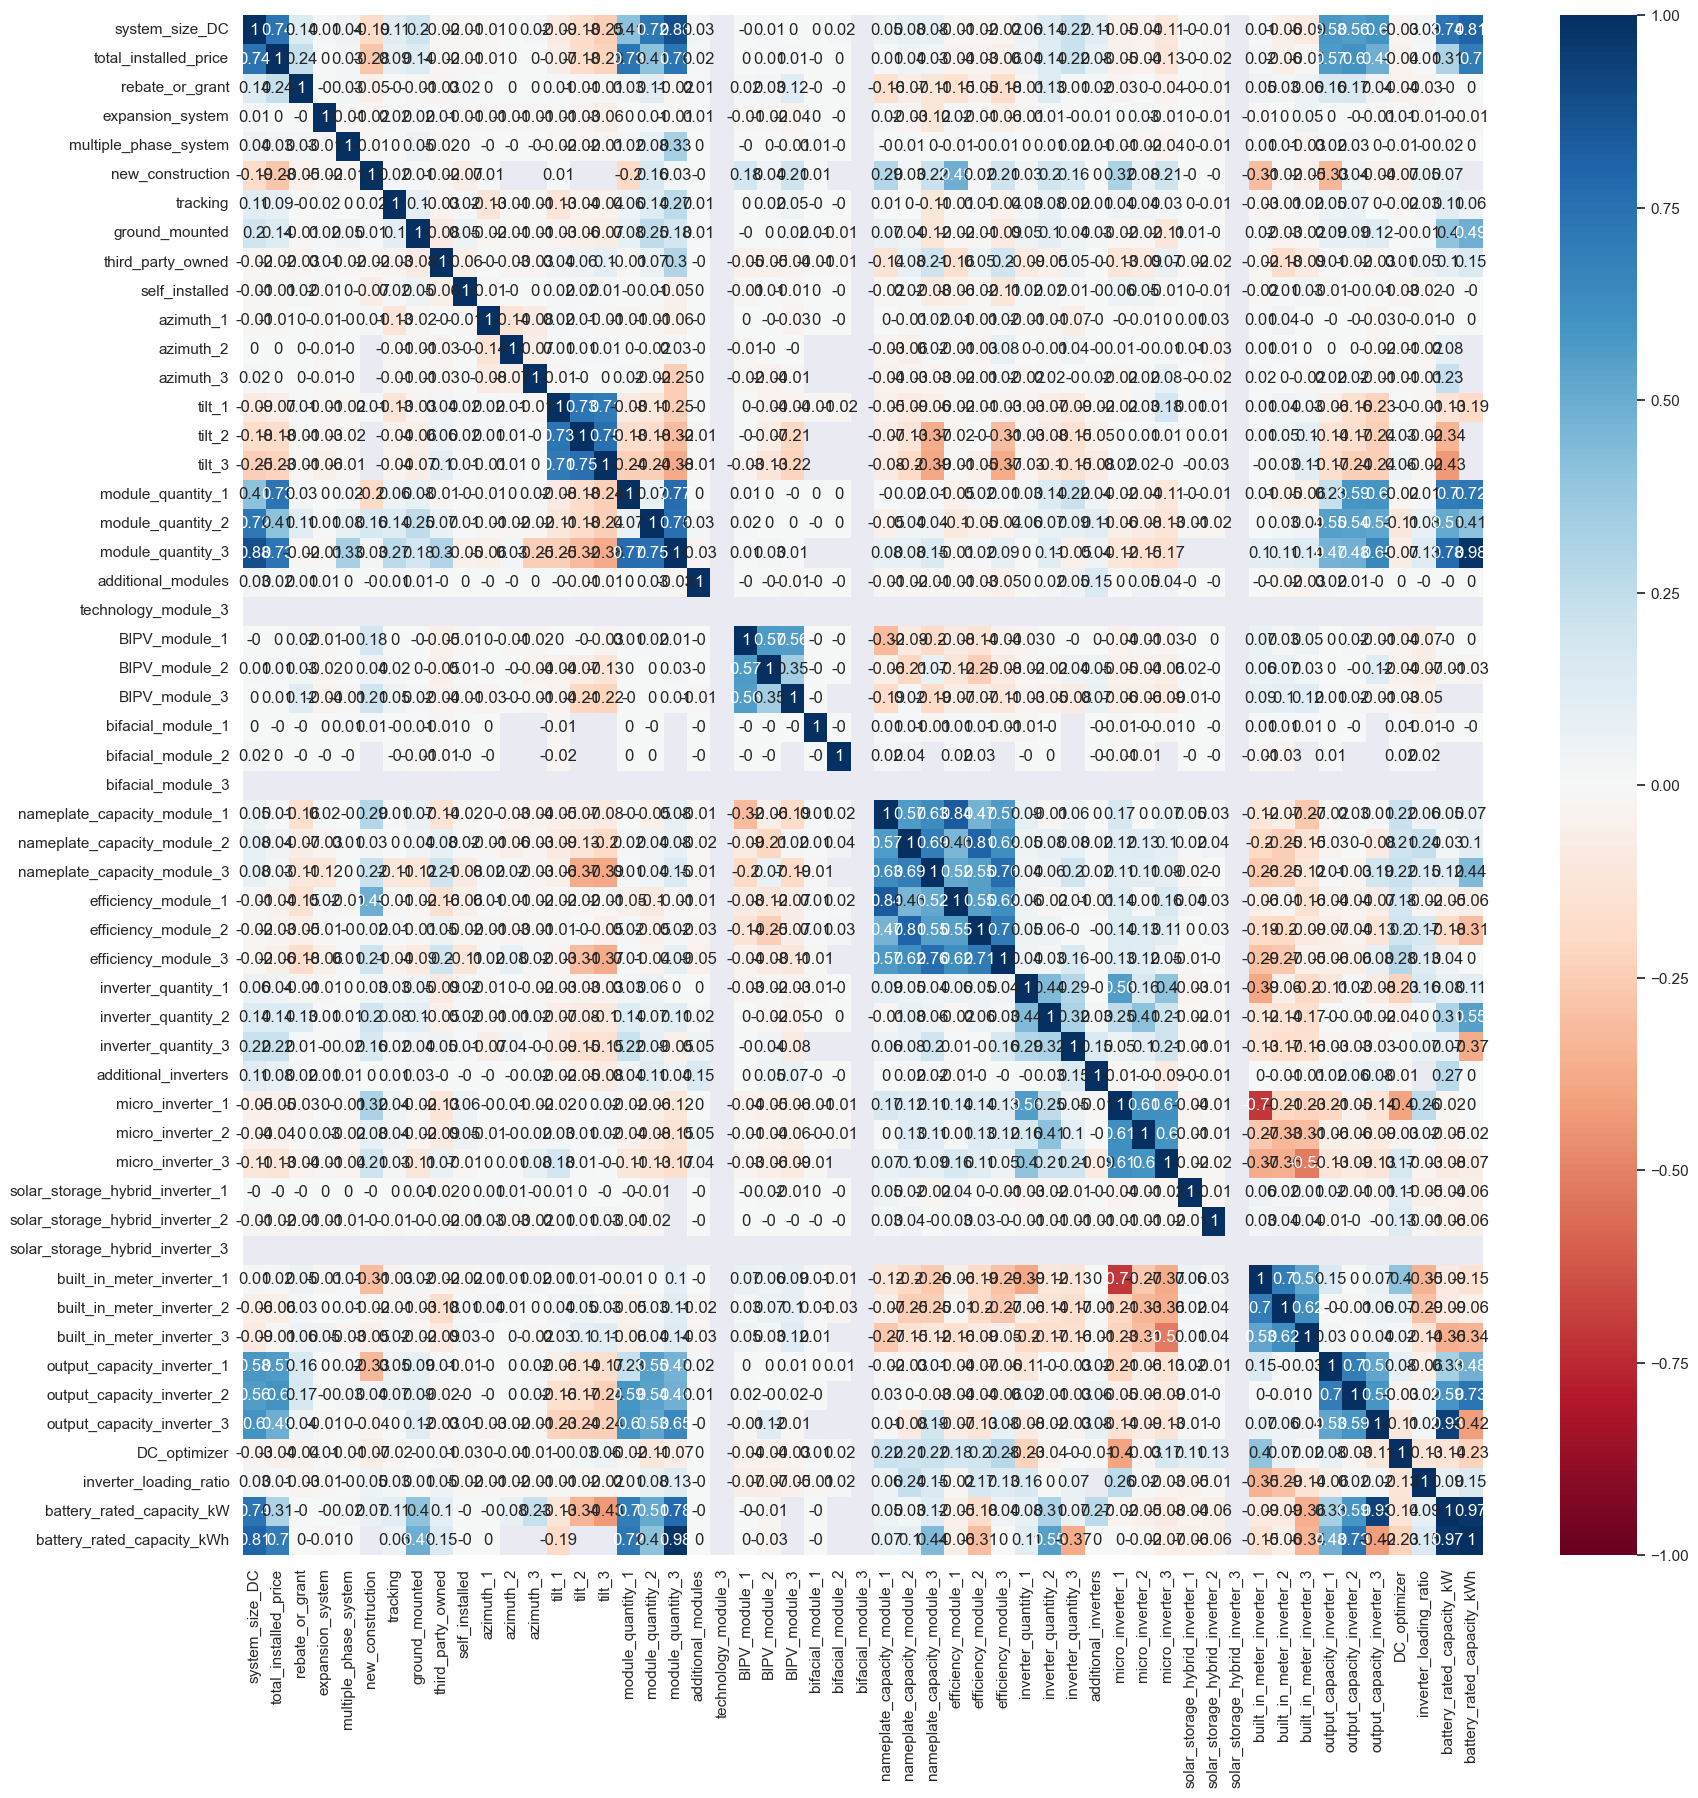

In [5]:
sns.set(rc={'figure.figsize':(20,20)})
corr = df.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

In [18]:
d = df.copy()
# vain kalifornia
d = d[d['state'] == "CA"]

# sarjanumerot ja lähteet
#d.drop(columns=['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2'] ,inplace=True)


#d['system_ID_1'].value_counts()

d.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 998971 entries, 105 to 999075
Data columns (total 78 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   data_provider_1                  998971 non-null  object 
 1   data_provider_2                  221982 non-null  object 
 2   system_ID_1                      998971 non-null  object 
 3   system_ID_2                      222098 non-null  object 
 4   installation_date                998971 non-null  object 
 5   system_size_DC                   987664 non-null  float64
 6   total_installed_price            813366 non-null  float64
 7   rebate_or_grant                  953631 non-null  float64
 8   customer_segment                 998971 non-null  object 
 9   expansion_system                 998971 non-null  float64
 10  multiple_phase_system            998971 non-null  float64
 11  new_construction                 207044 non-null  float64
 12  

Datasetissä yksi rivi vastaa siis yhtä aurinkopanelijärjestelmää. Yhdessä järjestelmässä voi olla useita eri tai saman valmistajan valmistamia aurinkopaneeleja, inverttereitä tai muita järjestelmän osia. Jos saman kategorian komponentteja on useita samassa järjestelmässä, ne on merkattu omaan sarakkeeseen. Tietoja on kerätty enintään kolmesta saman kategorian komponentista yhdessä järjestelmässä. Joissakin komponenteissa on vielä lisätieto, jos niitä on enemmän kuin 3. Valtaosassa aineiston järjestelmissä on vain yksi yksikkö kutakin komponenttia. 

Esimerkiksi:

In [7]:
df.iloc[120,27:37]

module_manufacturer_1       Hanwha Q CELLS
module_model_1           Q.PEAK DUO-G5 315
module_quantity_1                     49.0
module_manufacturer_2                  NaN
module_model_2                         NaN
module_quantity_2                      NaN
module_manufacturer_3                  NaN
module_model_3                         NaN
module_quantity_3                      NaN
additional_modules                     0.0
Name: 120, dtype: object

Järjestelmän hinta- ja tehotiedot ovat kuitenkin ilmoitettu koko järjestelmälle ja nämä tiedot ovat tässä projektissa oleellisimmat. Koska samankaltaista ja oletetusti ei niin oleellista tietoa on eri sarakkeissa paljon, yhdistetään samantyyppistä tietoa omiin sarakkeisiinsa. Tämän jälkeen datasetti on helpommin hahmotettavissa.

Tämä voi olla parempi tapa, kuin pudottaa sarakkeita kokonaan, jotta tietoa menetettäisiin mahdollisimma vähän.


In [8]:
# paneelien yhteenlaskettu määrä
d['module_quantity'] = d[['module_quantity_1','module_quantity_2','module_quantity_3']].sum(axis=1)

# järjestelmän paneelien hyötysuhteen keskiarvo
d['module_efficiency'] = d[['efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3']].mean(axis=1)

# Jos systeemissä on mikro-inverttereitä
d['micro_inverter'] = d[['micro_inverter_1', 'micro_inverter_2','micro_inverter_3']].sum(axis=1)
d.loc[d['micro_inverter'] > 0, 'micro_inverter'] = 1
# jos kaikki kolme sarakketta nan
d.loc[d[['micro_inverter_1', 'micro_inverter_2', 'micro_inverter_3']].isnull().all(axis=1),'micro_inverter']=np.nan


# Jos systeemissä on 'solar_storage_hybrid_inverter'
d['solar_storage_hybrid_inverter'] = d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3',]].sum(axis=1)
d.loc[d['solar_storage_hybrid_inverter'] > 0, 'solar_storage_hybrid_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3']].isnull().all(1),'solar_storage_hybrid_inverter']=np.nan


# Jos systeemissä on 'built_in_meter_inverter'
d['built_in_meter_inverter'] = d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2','built_in_meter_inverter_3']].sum(axis=1)
d.loc[d['built_in_meter_inverter'] > 0, 'built_in_meter_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2', 'built_in_meter_inverter_3']].isnull().all(axis=1),'built_in_meter_inverter']=np.nan


# Jos systeemissä on 'BIPV_module',
d['BIPV_module'] = d[['BIPV_module_1', 'BIPV_module_2', 'BIPV_module_3']].sum(axis=1)
d.loc[d['BIPV_module'] > 0, 'BIPV_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['BIPV_module_1','BIPV_module_2', 'BIPV_module_3']].isnull().all(axis=1),'BIPV_module']=np.nan


# Jos systeemissä on 'bifacial_module',
d['bifacial_module'] = d[['bifacial_module_1', 'bifacial_module_2', 'bifacial_module_3']].sum(axis=1)
d.loc[d['bifacial_module'] > 0, 'bifacial_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['bifacial_module_1','bifacial_module_2', 'bifacial_module_3']].isnull().all(axis=1),'bifacial_module']=np.nan
  
    
# nimellistehojen keskiarvo
d['nameplate_capacity'] = d[['nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3']].mean(axis=1)


# Invertterien määrä yhteensä
d['inverter_quantity'] = d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].sum(axis=1)
# jos kaikki kolme saraketta nan
d.loc[d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].isnull().all(axis=1),'inverter_quantity']=np.nan


# tilt-keskiarvo
d['tilt'] = d[['tilt_1','tilt_2', 'tilt_3']].mean(axis=1)

# suuntaus, tässä valtaosa datasta ensimmäisessä sarakkeessa ja esimerkikisi keskiarvon laskeminen ei järkevää
d['azimuth'] = d['azimuth_1']

# moduulin teknologia, tässä valtaosa datasta ensimmäisessä sarakkeessa ja technology_module_3 kokonaan NaN
d['technology_module'] = d['technology_module_1']



Invertterin tai useampien inverttereiden kokonaisteholle ei ole datasetissä saraketta, mutta järjestelmän ja invertterin tehon suhdeluku(inverter_loading_ratio) on ilmoitettu. Se on laskettu joko ilmoitettujen, tai arvioitujen arvojen perusteella. Tämän perusteella voidaan laskea invertterin koko, niissä järjestelmissä, joissa suhdeluku on ilmoitettu.

(yritys laskea inverterien määrän avulla?)

In [9]:
# Invertterin koko laskettuna inverter loading ration perusteella
d['inverter_total_capacity'] = d['system_size_DC'] /  d['inverter_loading_ratio']


Asiakassegmentti jaetaan asuinkiinteistöihin asennettuihin järjestelmiin ja muihin järjestelmiin.

In [10]:
# residential = 1, non-residental = 0
d['residential'] = np.where(d['customer_segment'] == "RES", 1, 0)

In [11]:
# Siivotaan yhdistetyt sarakkeet pois
d.drop(columns=[
       'module_quantity_1', 
       'module_quantity_2',
       'module_quantity_3', 'additional_modules','azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3','BIPV_module_1', 'technology_module_1', 'technology_module_2', 'technology_module_3',
       'BIPV_module_2', 'BIPV_module_3', 'BIPV_module','bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'bifacial_module','inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'inverter_manufacturer_2', 'inverter_model_2',
       'inverter_quantity_2', 'inverter_manufacturer_3', 'inverter_model_3',
       'inverter_quantity_3', 'additional_inverters', 'micro_inverter_1',
       'micro_inverter_2','micro_inverter_2','micro_inverter_3', 'efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3',
        'solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3', 'built_in_meter_inverter_1', 'built_in_meter_inverter_2',
       'built_in_meter_inverter_3','output_capacity_inverter_1',
       'output_capacity_inverter_2', 'output_capacity_inverter_3', 'nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3', 'customer_segment'], inplace=True)





In [12]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998971 entries, 105 to 999075
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   installation_date              998971 non-null  object 
 1   system_size_DC                 987664 non-null  float64
 2   total_installed_price          813366 non-null  float64
 3   rebate_or_grant                953631 non-null  float64
 4   expansion_system               998971 non-null  float64
 5   multiple_phase_system          998971 non-null  float64
 6   new_construction               207044 non-null  float64
 7   tracking                       899359 non-null  float64
 8   ground_mounted                 759359 non-null  float64
 9   zip_code                       998971 non-null  object 
 10  city                           998971 non-null  object 
 11  state                          998971 non-null  object 
 12  utility_service_territory   

<AxesSubplot:>

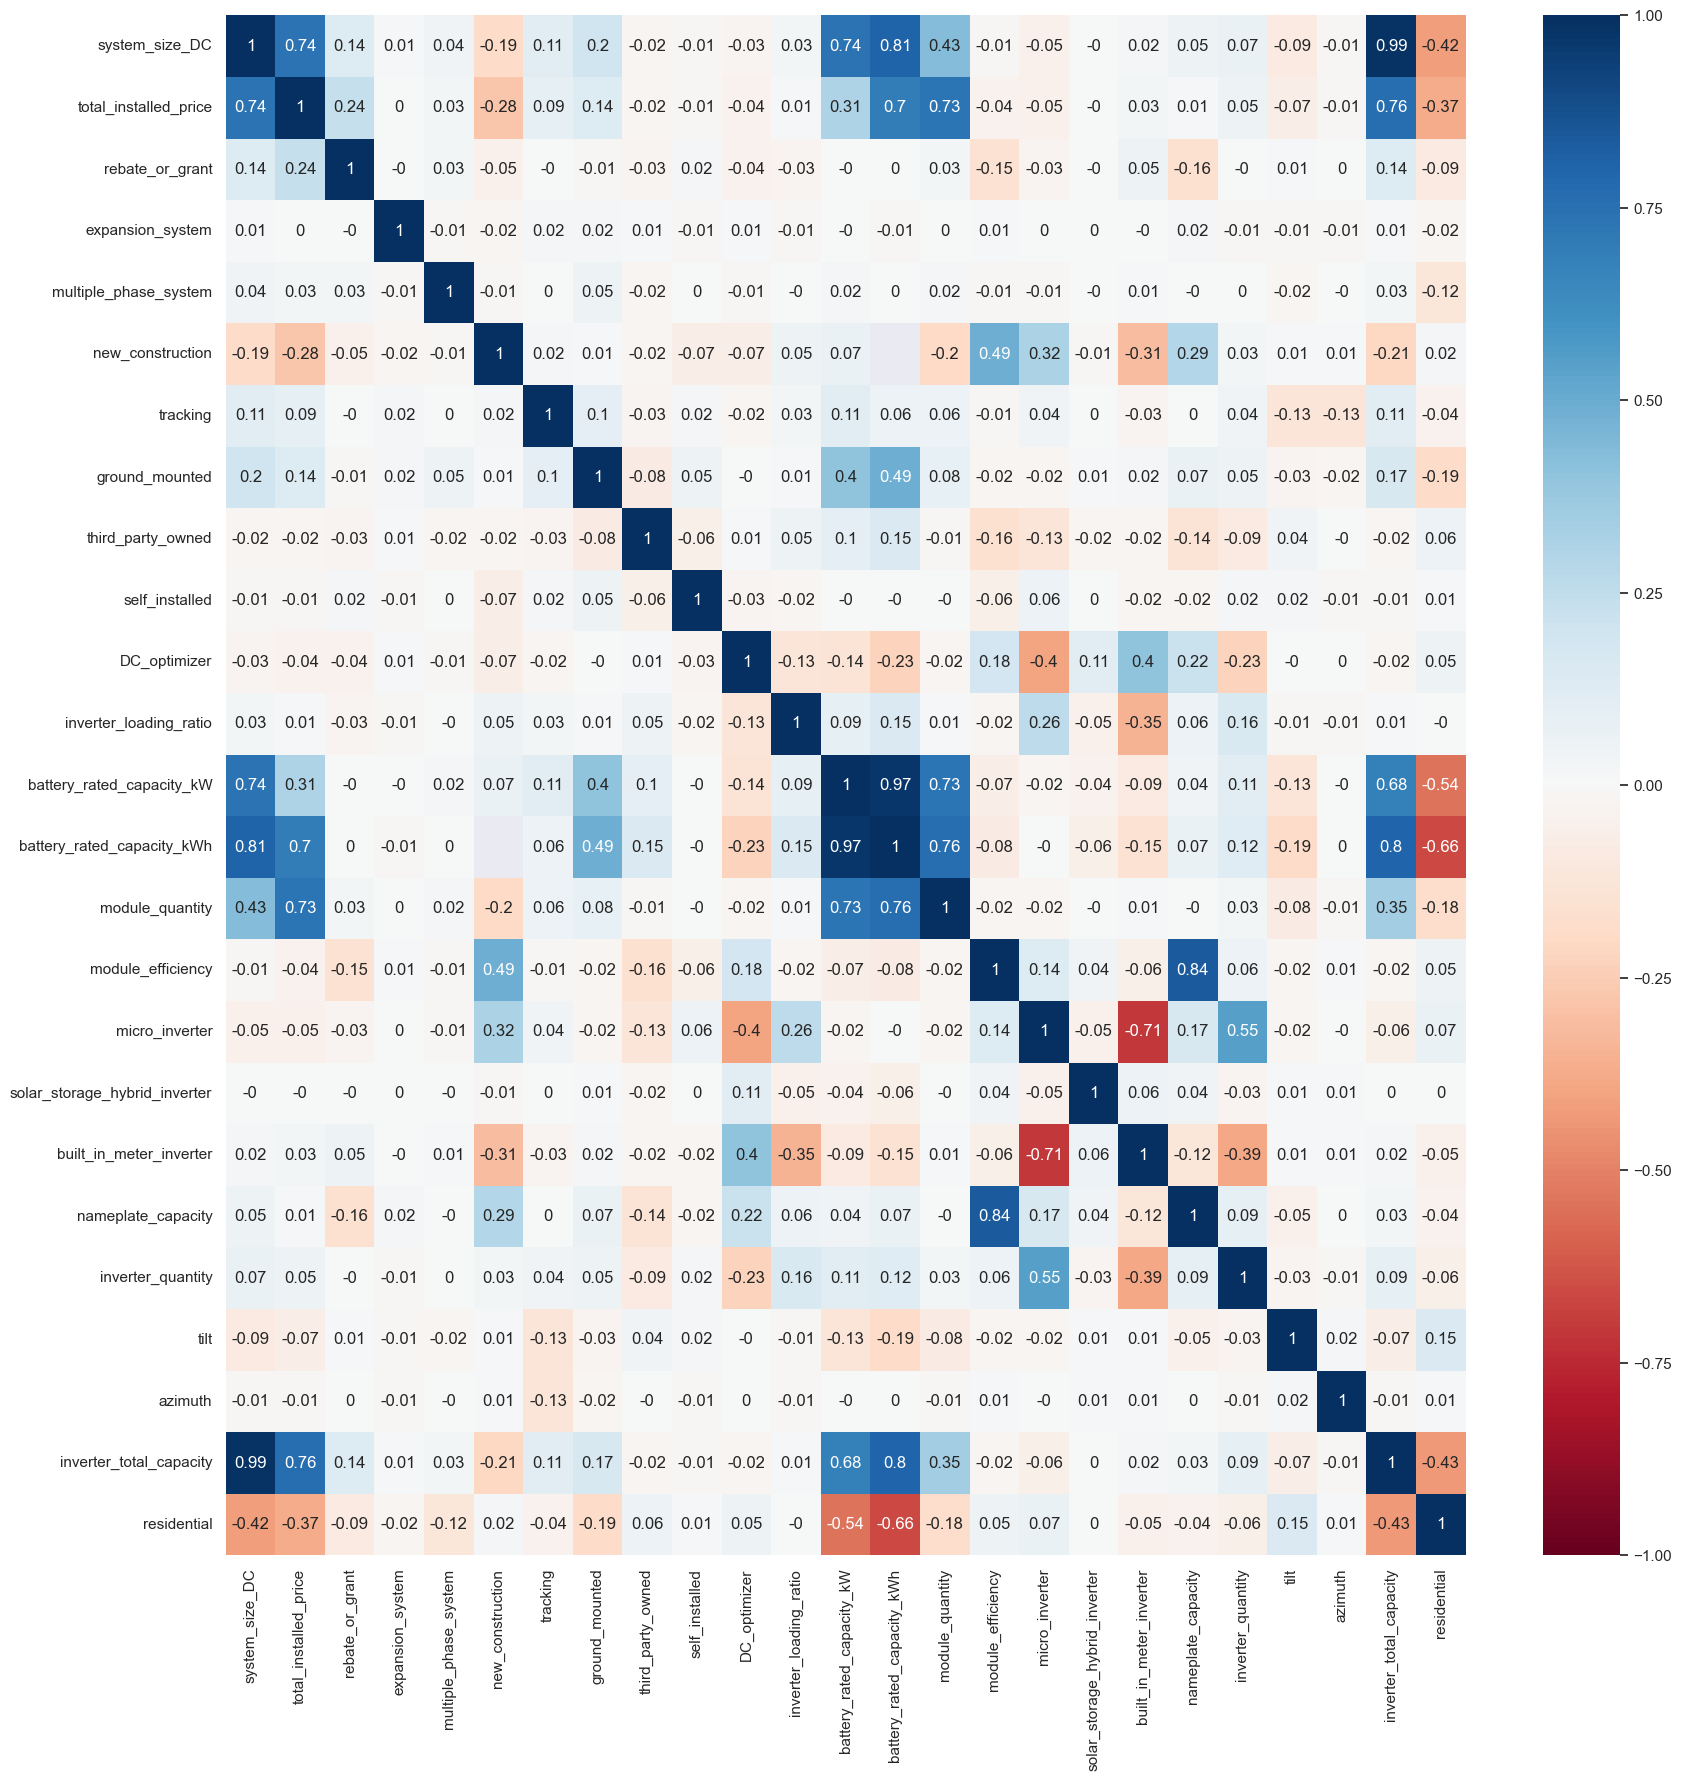

In [13]:
sns.set(rc={'figure.figsize':(20,20)})
corr = d.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

Nyt datasetissä on 998971 riviä ja sarakkeiden määrä on tippunut 38:aan. Datasetti nyt helpommn hahmotettavissa ja korrelaatio säilyy. 

In [14]:
df2 = d.copy()


res = df2[df2['residential'] == 1]
non_res = df2[df2['residential'] == 0]

#res_price_per_kw = res['total_installed_price'] / res['system_size_DC']
#res_avg_price_per_kw = res_price_per_kw.mean()
#res['total_installed_price'].fillna(round(res_avg_price_per_kw * res['system_size_DC'], 2) , inplace=True)


non_res.info()

res.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25610 entries, 118 to 999064
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   installation_date              25610 non-null  object 
 1   system_size_DC                 25098 non-null  float64
 2   total_installed_price          19602 non-null  float64
 3   rebate_or_grant                22520 non-null  float64
 4   expansion_system               25610 non-null  float64
 5   multiple_phase_system          25610 non-null  float64
 6   new_construction               289 non-null    float64
 7   tracking                       21592 non-null  float64
 8   ground_mounted                 17410 non-null  float64
 9   zip_code                       25610 non-null  object 
 10  city                           25610 non-null  object 
 11  state                          25610 non-null  object 
 12  utility_service_territory      25610 non-nu

TypeError: Vertical orientation requires numeric `y` variable.

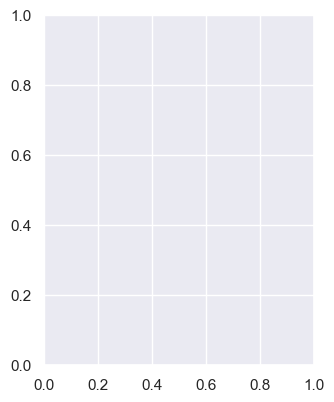

In [15]:
plt.figure(figsize=(16,10))

features = res.columns.tolist()

for i,col in enumerate(features):    
    plt.subplot(2,4,i + 1)
    sns.boxplot(y=col, data=res)
    #plt.ylabel('')

plt.tight_layout()

plt.show()